<a href="https://colab.research.google.com/github/amaye15/CanineNet/blob/main/code/ModelFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model From Scratch

In [1]:
%pip install torchview mlflow datasets==2.15.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [ ]:


# # Set the experiment by name
# mlflow.set_experiment("CanineNet")
# mlflow.start_run()
# mlflow.end_run()

In [7]:
import io
import os
import cv2
import datasets
import torch
import torchview
import pyarrow_hotfix
import mlflow
import mlflow.pytorch
import graphviz

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim

from PIL import Image
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from datasets import load_dataset, ClassLabel, Value
from functools import partial
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torchview import draw_graph



pyarrow_hotfix.uninstall()
graphviz.set_jupyter_format('png')

os.environ['MLFLOW_TRACKING_USERNAME'] = "andrewmayes14"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "ccb096afadd26486a787461f3495219662998c4b"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "mlflow"

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                         + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

mlflow.set_experiment("CanineNet")

# Constants
DATASET = "Alanox/stanford-dogs"
REMOVE_COLS_V1 = ["name", "annotations"]
REMOVE_COLS_V2 = ["name", "annotations", "image"]
NAME_COLS = {"index": "label", 0: "count"}
SPLIT = 0.5
IMAGE_SIZE = (256, 256)
OPS = 10

# Load the dataset
dataset = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V1)# .train_test_split(test_size=SPLIT, stratify_by_column="target") #, streaming=True)

### This is a bit of a work aroound to get even class seperation
target_df = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V2).to_pandas().value_counts().reset_index().reset_index().rename(columns=NAME_COLS)
# Convert the target column to a list and find unique classes
unique_classes = set(target_df['target'])
# Define the ClassLabel feature
class_label_feature = ClassLabel(num_classes=len(unique_classes), names=list(unique_classes))
# Update the dataset schema to use ClassLabel for the target column
dataset = dataset.cast_column('target', class_label_feature)
###

# Split Dataset
dataset = dataset.train_test_split(test_size=SPLIT, stratify_by_column = "target")

# Display Images Function
def display_random_images(dataset, key = "image", number_of_images=9, image_size=(128, 128), grid_size=(3, 3)):
    """
    Displays a specified number of random images from a Hugging Face dataset in a grid layout.

    Parameters:
    dataset: The dataset to use.
    number_of_images (int): The number of images to display.
    image_size (tuple): The size (width, height) to which each image will be resized.
    grid_size (tuple): The grid size (rows, columns) for displaying the images.
    """

    # Shuffle the dataset
    shuffled_dataset = dataset.shuffle(seed=np.random.randint(0, 1000))

    # Determine the number of rows and columns in the grid
    rows, cols = grid_size

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, ax in enumerate(axes):
        if i < number_of_images:
            # Decode and resize the image
            image_data = shuffled_dataset[i][key]
            image = image_data
            image = image.resize(image_size)

            # Display the image
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide extra subplots if the number of images is less than grid cells
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def transforms(examples, transformation_function = None, to_tensor: bool = False, image_size: tuple = (256, 256)):
    if to_tensor & callable(transformation_function):
      examples["image"] = [v2.functional.pil_to_tensor(transformation_function(image.convert("RGB"))) for image in examples["image"]]
    if to_tensor & (callable(transformation_function) == False):
      examples["image"] = [v2.functional.pil_to_tensor(v2.functional.resize(image.convert("RGB"), size = image_size)) for image in examples["image"]]
    if (to_tensor == False) & callable(transformation_function):
      examples["image"] = [transformation_function(image.convert("RGB")) for image in examples["image"]]
    return examples

#display_random_images(dataset)

# Random Transformations

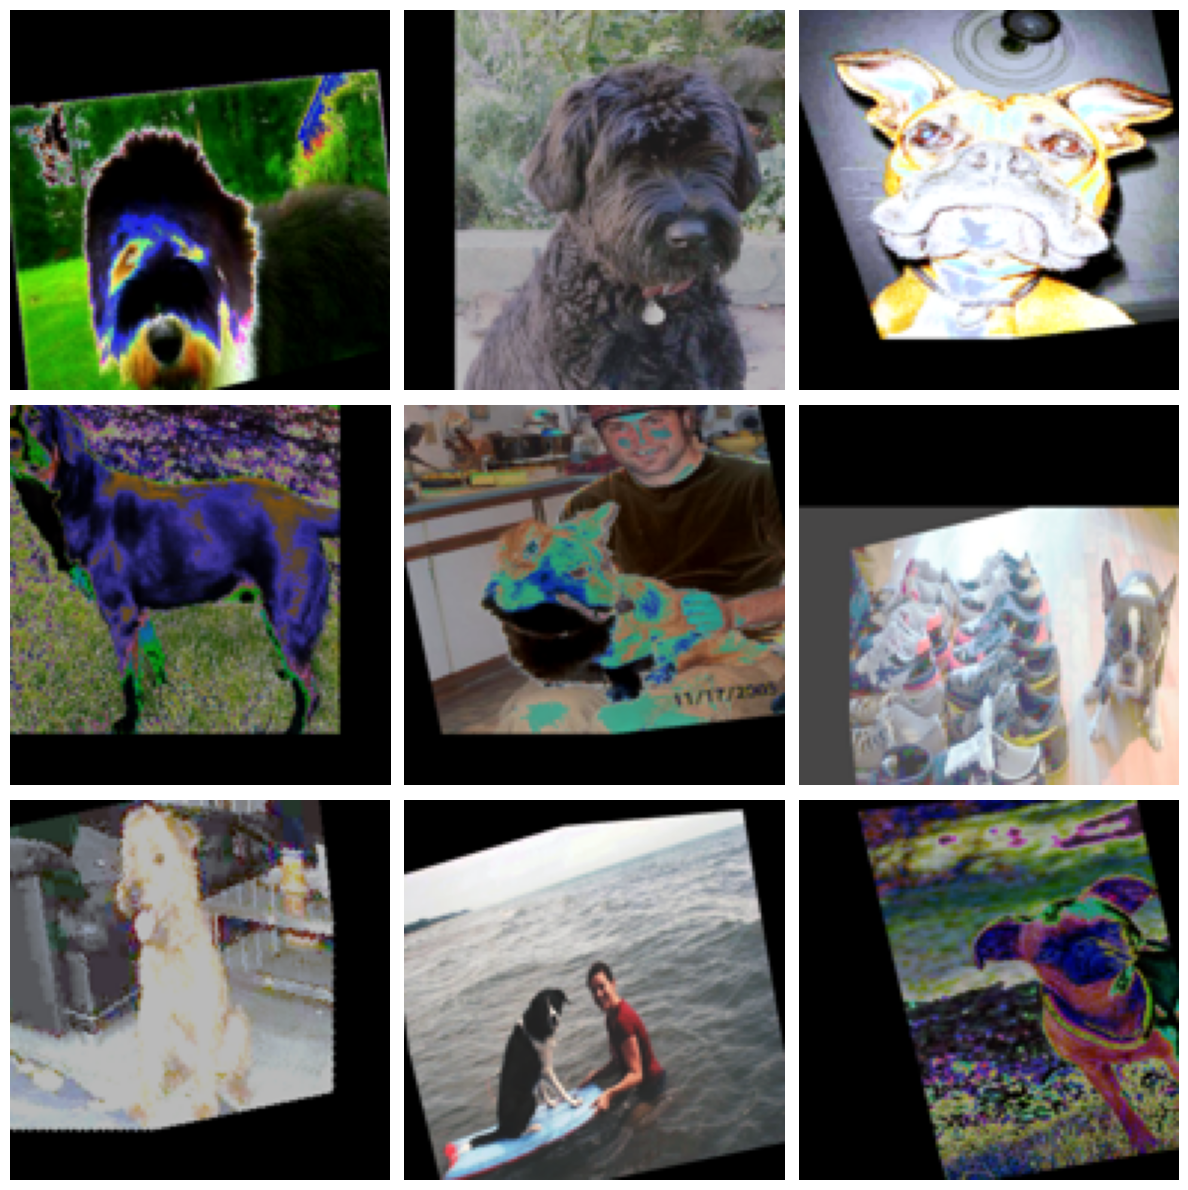

In [8]:
transformation = v2.Compose([v2.RandAugment(num_ops = OPS), v2.Resize(size = IMAGE_SIZE)])
dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = False))
display_random_images(dataset["train"], key = "image")

# Model

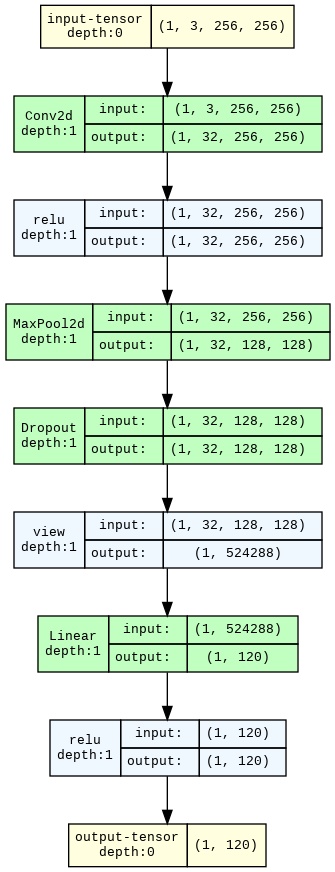

In [22]:
class CNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, input_size, dropout_rates=None, activation_fn=F.relu, pool_fn=nn.MaxPool2d(kernel_size=2, stride=2)):
        super(CNN, self).__init__()
        self.activation_fn = activation_fn
        self.pool_fn = pool_fn

        self.conv_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        output_size = input_size[1:]

        for i, (in_channels, out_channels, kernel_size, stride, padding) in enumerate(conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            # Convolution output size calculation for each dimension
            output_size = [((size + 2 * padding - kernel_size) // stride) + 1 for size in output_size]
            # Pooling operation (halves the size due to kernel_size=2, stride=2)
            output_size = [size // 2 for size in output_size]
            last_channels = out_channels
            if dropout_rates and i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            else:
                self.dropouts.append(nn.Identity())  # No dropout

        flatten_size = last_channels * output_size[0] * output_size[1]

        self.fc_layers = nn.ModuleList()
        for out_features in fc_layers:
            self.fc_layers.append(nn.Linear(flatten_size, out_features))
            flatten_size = out_features

    def forward(self, x):
        for conv, dropout in zip(self.conv_layers, self.dropouts):
            x = dropout(self.pool_fn(self.activation_fn(conv(x))))

        x = x.view(x.size(0), -1)  # Flatten

        for i, fc in enumerate(self.fc_layers):
            x = self.activation_fn(fc(x))
            if i < len(self.fc_layers) - 1:
                x = self.dropouts[i](x)  # Apply corresponding dropout

        return x


# Model Config
convLayers = [(3, 32, 3, 1, 1)]
# [(3, 32, 3, 1, 1), (32, 64, 3, 1, 1), (64, 32, 3, 1, 1), (32, 16, 3, 1, 1)]
fcLayers = [target_df.shape[0]]
imageSize = (3, 256, 256)
dpRates = [0.1]

# Model
model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)

model_graph = draw_graph(model, input_size=(1, 3, 256, 256), device='meta', roll=True)
model_graph.visual_graph

In [23]:
run = mlflow.start_run()

# mlflow.pytorch.log_model(model, "model")

# Train Config
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRANSFORM = True


# Model
model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)

# Criteria & Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Device
model.to(DEVICE)

# Log parameters
mlflow.log_param("epochs", EPOCHS)
mlflow.log_param("learning_rate", LEARNING_RATE)
mlflow.log_param("batch_size", BATCH_SIZE)
mlflow.log_param("image_transformation", TRANSFORM)
mlflow.log_param("layers", len(convLayers))

train_step = 0
test_step = 0

# Model, Criterion, Optimizer setup remains the same
for epoch in range(EPOCHS):

  if TRANSFORM:
    # Transformation and dataset settings as before
    transformation = v2.Compose([v2.RandAugment(num_ops = OPS), v2.Resize(size = IMAGE_SIZE)])
    dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = True,))
  else:
    # Transformation and dataset settings as before
    transformation = v2.Compose([v2.Resize(size = IMAGE_SIZE)])
    dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = True,))

  # Train
  model.train()
  for batch in DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True):
      optimizer.zero_grad()
      output = model(batch["image"].float().to(DEVICE))
      loss = criterion(output, batch["target"].to(DEVICE))
      loss.backward()
      optimizer.step()

      train_step += 1

      # Compute training metrics
      train_accuracy = accuracy_score(batch["target"].numpy(), output.argmax(dim=1).cpu().numpy())
      train_precision, train_recall, train_f1, train_support = precision_recall_fscore_support(batch["target"].numpy(),
                                                                                               output.argmax(dim=1).cpu().numpy(),
                                                                                               average='macro',
                                                                                               zero_division = 0.0)

      # Log training metrics
      mlflow.log_metrics({'train_loss': loss.item(),
                          'train_accuracy': train_accuracy,
                          'train_precision': train_precision,
                          'train_recall': train_recall,
                          'train_f1': train_f1,}, step = train_step)

  # Test
  model.eval()
  with torch.no_grad():
      for batch in DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False):
          output = model(batch["image"].float().to(DEVICE))
          loss = criterion(output, batch["target"].to(DEVICE))

          test_step += 1

          # Compute testing metrics
          test_accuracy = accuracy_score(batch["target"].numpy(), output.argmax(dim=1).cpu().numpy())
          test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(batch["target"].numpy(),
                                                                                               output.argmax(dim=1).cpu().numpy(),
                                                                                               average='macro',
                                                                                               zero_division = 0.0)
          # Log testing metrics
          mlflow.log_metrics({'test_loss': loss.item(),
                              'test_accuracy': test_accuracy,
                              'test_precision': test_precision,
                              'test_recall': test_recall,
                              'test_f1': test_f1,}, step = test_step)

    # # Log Confusion Matrix as an artifact
    # cm = confusion_matrix(all_test_labels, all_test_preds)
    # plt.figure(figsize=(10,7))
    # #sns.heatmap(cm, annot=True)
    # sns.heatmap(cm, annot=False)
    # plt.xlabel('Predicted')
    # plt.ylabel('Truth')
    # plt.title(f'Confusion Matrix at Epoch {epoch}')
    # plt.savefig("confusion_matrix.png")
    # mlflow.log_artifact("confusion_matrix.png")

mlflow.end_run()

In [20]:
mlflow.end_run()